In this paper, we trained a neural network model, where the input of the model is a star's BP-RP color and its absolute G-band magnitude and the output is the mass of the star. **In this notebook, we demonstrate how to load the trained model and output the mass on your own.** In another notebook, we provide the code to train your own neural network model.

You can use Google Colab to run this Jupyter notebook (e.g. put this juputer notebook in your Google Drive and open it). Google Colab provides free (at least at the time of writing) GPU that is sufficient for our purposes. You can also run the notebook on your laptop, but GPU may not be available depending on your system. Our codes are mainly developed and tested on the Google Colab environment (with GPU). The free Colab GPU is T4 (at the time of writing), which is sufficient for most of the work here. You can get access to a more powerful GPU if you have a Colab subscription.

If your are using Google Colab (like me), first activate your GPU ("Runtime"->"Change runtime type"). Then we mount the Google Drive (i.e. let this code to get access to the files in your Google Drive). You will get a pop-up window asking you about the permission. Answer "Allow" (if you would like to continue).

In [34]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After mounting, we change the directory ("%cd ...") to our working directory. You may want to change the path name below for your case.

In [ ]:
%cd drive/My\ Drive/colab/2022_5_mass_across_HR_diagram/3_reanalysis/26_Github\ files

## Approach 1: load the model using PyTorch

The first approach to load the trained model is to use [PyTorch](https://pytorch.org/), a machine learning library. This is the most fundamental way to get access to the model, and one should be able to reproduce all the plots in the paper using this method. The disadvantage is that the code sometimes is more complex because it has to deal with GPU (even worse, the code may not be compatible with CPU-only environments).

In [3]:
import torch
from torch import nn

print(torch.__version__)

2.0.1+cu118


Then, import the "binary_training_v1" module we developed. This module includes the neural network structures necessary to load the trained model.

In [4]:
import binary_training_v1

import importlib
importlib.reload(binary_training_v1)

from binary_training_v1 import *

v72
v72


Create a BinaryTraining object from binary_training_v1 module. Since we do not provide a wide binary catalog here, you will see a warning about it.

In [5]:
#Since we do not provide binary table, some functions of the class may not be working.
bt = BinaryTraining()

For model-loading only. No binary table is loaded. Some functions may not be working.


Now we initialize a neural network. The parameters are specifically for the model we are going to load later and should not be changed.

In [6]:
#initialize the model: 2 input, 128 neurons per layer, 1 output, 0.2 dropout rate
#these are the parameters used in the paper
bt.model = mmodel_2(2, 128, 1, 0.2)
if torch.cuda.is_available():
    bt.device = 'cuda'
    bt.model.cuda()
    print('GPU is available')
else:
    bt.device = 'cpu'
    print('CPU mode. Warning: some functions may not be compatible.')

GPU is available


In [42]:
# load the trained model
model_path = './trained_model_20230809.pth'
if torch.cuda.is_available():
    state_dict = torch.load(model_path)
else:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))

bt.model.load_state_dict(state_dict)

<All keys matched successfully>

Now you can output the mass given the BP-RP color and the absolute G magnitude! Note that the model output is actually the exponent of the mass (to avoid negative mass), so the mass you want is actually exp(model_output), which is in units of solar masses.

Let's consider our Sun, which has approximately BP-RP=0.82 and M_G = 4.67. Then its mass from the neural network model is:

In [47]:
torch.exp(bt.model(torch.tensor([[0.82, 4.67]]).to(bt.device)))

tensor([[1.0691]], device='cuda:0', grad_fn=<ExpBackward0>)

The line above will give you "one measurement" of the Sun's mass from the model. If you run the line multiple times, you will see that the value changes every time. This is not because there is some problem in the code. It's because we want to have an uncertainty estimate, which is done by having dropout activated during the prediction. Therefore, by running this multiple times, the spread of the measurements provides the uncertainty. Below is the example for the Sun, where we sample 1000 times and report the median as the mass measurement value and the standard deviation as the mass uncertainty.

In [49]:
sun_prediction = torch.exp(bt.model(torch.tensor([[0.82, 4.67]]*1000).to(bt.device))).detach().cpu().flatten()

print('Sun-like star\'s mass: %.3f +/- %.3f Msun' %(torch.median(sun_prediction), torch.std(sun_prediction)))

Sun-like star's mass: 0.961 +/- 0.076 Msun


Looks nice!!

**Warning**: the model does not check if the input (BP-RP and G) is a valid point in the H-R diagram. It also does not check if there are sufficient training data around that point (for example, no training data for AGB stars). We recommend that the user makes sure that are sufficient training data from the wide binaries around the location of interest.

You can also use the BinaryTraining() object to load a wide binary table and get all their component masses. We first read the wide binary catalog ([El-Badry+21]( https://ui.adsabs.harvard.edu/abs/2021MNRAS.506.2269E/abstract). Available here: https://zenodo.org/record/4435257 . 1.4 GB) using astropy. Loading the table may take about 1 min.

In [50]:
from astropy.table import Table
sample_file_name = 'all_columns_catalog.fits.gz'
wb_table = Table.read(sample_file_name)



Then we need to pre-calculate some values (otherwise cannot be loaded to the BinaryTraining() object) for the wide binary table.

In [51]:
import numpy as np
wb_table['sep_arcsec'] = wb_table['pairdistance'] * 3600.

wb_table['dpmra'] = wb_table['pmra2'] - wb_table['pmra1']
wb_table['dpmdec'] = wb_table['pmdec2'] - wb_table['pmdec1']
wb_table['dpmradec'] = np.sqrt(wb_table['dpmra']**2 + wb_table['dpmdec']**2)

wb_table['dpm_error'] = 1. / wb_table['dpmradec'] * np.sqrt(
        wb_table['dpmra']**2 * (wb_table['pmra_error1']**2 + wb_table['pmra_error2']**2) +
        wb_table['dpmdec']**2 * (wb_table['pmdec_error1']**2 + wb_table['pmdec_error2']**2)
    )

wb_table['dpm_over_error'] = wb_table['dpmradec'] / wb_table['dpm_error']

Apply the target selection criteria (detailed in the paper) and then initialize a BinaryTraining() object:

In [52]:

s_wb_to_use = (
    (wb_table['phot_bp_mean_flux_over_error1'] > 10.) *
    (wb_table['phot_rp_mean_flux_over_error1'] > 10.) *
    (wb_table['phot_g_mean_flux_over_error1'] > 10.) *
    (wb_table['phot_bp_mean_flux_over_error2'] > 10.) *
    (wb_table['phot_rp_mean_flux_over_error2'] > 10.) *
    (wb_table['phot_g_mean_flux_over_error2'] > 10.) *
    (wb_table['bp_rp1'] < 5.) *
    (wb_table['bp_rp2'] < 5.) *
    (wb_table['R_chance_align'] < 0.01) *
    (wb_table['sep_arcsec'] > 2.) *
    (wb_table['sep_AU'] < 10**3.5) *
    (wb_table['parallax1'] > 2.5) *
    (wb_table['parallax_over_error1'] > 10.) *
    (wb_table['ruwe1'] < 1.4) *
    (wb_table['ruwe2'] < 1.4) *
    (wb_table['phot_bp_rp_excess_factor1'] < 1.8) *
    (wb_table['phot_bp_rp_excess_factor2'] < 1.8) *
    (np.abs(wb_table['b1']) > 10.)
)

print(np.sum(s_wb_to_use))

bt = BinaryTraining(wb_table[s_wb_to_use], 'Gaia')

99680
torch version: 2.0.1+cu118
self.device:  cuda


And don't forget to load the model:

In [54]:
bt.model = mmodel_2(2, 128, 1, 0.2)
if torch.cuda.is_available():
    bt.device = 'cuda'
    bt.model.cuda()
else:
    bt.device = 'cpu'

model_path = './trained_model_20230809.pth'
if torch.cuda.is_available():
    state_dict = torch.load(model_path)
else:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))

bt.model.load_state_dict(state_dict)

<All keys matched successfully>

Generate the mass for the stars by sampling 1000 times. This step can be done in 1 min using T4 GPU or better.

In [55]:
bt.derive_predict_median_mass_from_sampling()

  0%|          | 0/1000 [00:00<?, ?it/s]

**The we can make my favorite plot of the paper, the mass across the Hertzsprung-Russell Diagram!**

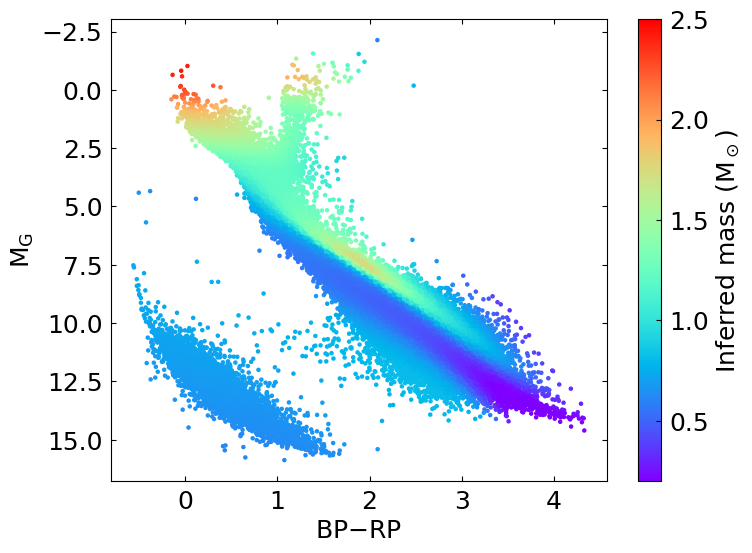

In [56]:
bt.plot_training_result()

#Approach 2: scipy interpolation from existing measurements #



Another approach is to interpolate from the measurements of wide binaries using scipy's "griddata" function. This approach does not involve PyTorch and GPU. However, the disadvantage is that "griddata" function is quite slow.

First, we read the table that contains our training sample with their mass measurements.

In [57]:
from astropy.table import Table

wb_table_with_mass = Table.read('./20230810_wb_table_with_mass.fits')

Then we initialize the functions for interpolation:

In [58]:
import numpy as np
from scipy.interpolate import griddata

points = np.array([np.concatenate((wb_table_with_mass['bp_rp1'], wb_table_with_mass['bp_rp2'])),
                   np.concatenate((wb_table_with_mass['absg1'], wb_table_with_mass['absg2']))]).T

mass_values = np.concatenate((wb_table_with_mass['predict_mass1_median'], wb_table_with_mass['predict_mass2_median']))
error_values = np.concatenate((wb_table_with_mass['predict_mass1_error'], wb_table_with_mass['predict_mass2_error']))

def interpolated_mass(bprp, absg):
    return griddata(points, mass_values, (bprp, absg), method='linear')

def interpolated_mass_error(bprp, absg):
    return griddata(points, error_values, (bprp, absg), method='linear')

We can now get the mass measurement, for example, for a Sun-like star:

In [59]:
print('Sun-like star\'s mass: %.3f +/- %.3f Msun' %(interpolated_mass(0.82, 4.67), interpolated_mass_error(0.82, 4.67)))

Sun-like star's mass: 0.962 +/- 0.078 Msun
